### Import Library

In [45]:
### Import Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from feature_engine.outliers import OutlierTrimmer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, RandomForestRegressor, VotingClassifier, StackingRegressor
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from imblearn.over_sampling import SMOTE, ADASYN

## **1. Data Understanding**

In [46]:
train = pd.read_csv("Train Set.csv", header=0, encoding='unicode_escape', delimiter=';')

train = train.replace(',', '.', regex=True)

train.head()

,ID,time,temperature_2m (EEC),relative_humidity_2m (%),dew_point_2m (EEC),apparent_temperature (EEC),precipitation (mm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),...,soil_moisture_100_to_255cm (m?/m?),shortwave_radiation (W/m?),direct_radiation (W/m?),diffuse_radiation (W/m?),direct_normal_irradiance (W/m?),global_tilted_irradiance (W/m?),terrestrial_radiation (W/m?),is_day (),sunshine_duration (s),electricity_shutdown
0,1,2022-01-01T00:00,NaN,91.0,20.7,25.7,0.1,1011.4,987.2,52.0,...,0.323,0,0,0,0,0,0,0,0,0.0
1,2,2022-01-01T01:00,22.2,89.0,20.3,25.5,0,1010.9,986.7,NaN,...,0.323,0,0,0,0,0,0,0,0,0.0
2,3,2022-01-01T02:00,NaN,87.0,20.2,25.4,0,1010,985.8,42.0,...,0.323,0,0,0,0,0,0,0,0,0.0
3,4,2022-01-01T03:00,22.5,86.0,20.1,25.1,0,1010,985.8,43.0,...,0.323,0,0,0,0,0,0,0,0,0.0
4,5,2022-01-01T04:00,22.7,84.0,19.9,25.6,0,1009.8,985.7,NaN,...,0.323,0,0,0,0,0,NaN,0,0,0.0


In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID                                     17520 non-null  int64  
 1   time                                   17520 non-null  object 
 2   temperature_2m (EEC)                 9499 non-null   object 
 3   relative_humidity_2m (%)               15761 non-null  float64
 4   dew_point_2m (EEC)                   17520 non-null  object 
 5   apparent_temperature (EEC)           17520 non-null  object 
 6   precipitation (mm)                     13978 non-null  object 
 7   pressure_msl (hPa)                     17520 non-null  object 
 8   surface_pressure (hPa)                 15706 non-null  object 
 9   cloud_cover (%)                        13169 non-null  float64
 10  cloud_cover_low (%)                    13979 non-null  float64
 11  cl

In [48]:
print("Data Shape: ", train.shape)

Data Shape:  (17520, 36)


In [49]:
train.columns = [
    'ID', 'time', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 
    'apparent_temperature', 'precipitation', 'pressure_msl', 'surface_pressure', 
    'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 
    'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 
    'wind_direction_100m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm', 
    'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm', 
    'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 
    'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm', 'shortwave_radiation', 
    'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance', 
    'global_tilted_irradiance', 'terrestrial_radiation', 'is_day', 
    'sunshine_duration', 'electricity_shutdown'
]

In [50]:
object_columns = train.select_dtypes(include=['object'])
object_column_names = object_columns.columns
print(object_column_names)

Index(['time', 'temperature_2m', 'dew_point_2m', 'apparent_temperature',
       'precipitation', 'pressure_msl', 'surface_pressure',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m',
       'wind_gusts_10m', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm',
       'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
       'soil_moisture_100_to_255cm', 'direct_normal_irradiance',
       'terrestrial_radiation', 'sunshine_duration'],
      dtype='object')


## **2. Data Preprocessing**

### Change Data Type from Object to Float

In [51]:
object_to_float = [
    'temperature_2m', 'dew_point_2m', 'apparent_temperature',
    'precipitation', 'pressure_msl', 'surface_pressure',
    'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m',
    'wind_gusts_10m', 'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
    'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm',
    'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
    'soil_moisture_100_to_255cm', 'direct_normal_irradiance', 'terrestrial_radiation',
    'sunshine_duration'
]

train[object_to_float] = train[object_to_float].astype(float)

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             17520 non-null  int64  
 1   time                           17520 non-null  object 
 2   temperature_2m                 9499 non-null   float64
 3   relative_humidity_2m           15761 non-null  float64
 4   dew_point_2m                   17520 non-null  float64
 5   apparent_temperature           17520 non-null  float64
 6   precipitation                  13978 non-null  float64
 7   pressure_msl                   17520 non-null  float64
 8   surface_pressure               15706 non-null  float64
 9   cloud_cover                    13169 non-null  float64
 10  cloud_cover_low                13979 non-null  float64
 11  cloud_cover_mid                14896 non-null  float64
 12  cloud_cover_high               17520 non-null 

### Check Missing Values and Data Duplication

In [53]:
train = train.drop(columns = ['ID', 'time'])

In [54]:
train.isnull().sum()

temperature_2m                   8021
relative_humidity_2m             1759
dew_point_2m                        0
apparent_temperature                0
precipitation                    3542
pressure_msl                        0
surface_pressure                 1814
cloud_cover                      4351
cloud_cover_low                  3541
cloud_cover_mid                  2624
cloud_cover_high                    0
vapour_pressure_deficit          1784
wind_speed_10m                   3492
wind_speed_100m                     0
wind_direction_10m               1699
wind_direction_100m              1796
wind_gusts_10m                   2604
soil_temperature_0_to_7cm           0
soil_temperature_7_to_28cm          0
soil_temperature_28_to_100cm        0
soil_temperature_100_to_255cm       0
soil_moisture_0_to_7cm              0
soil_moisture_7_to_28cm             0
soil_moisture_28_to_100cm        1727
soil_moisture_100_to_255cm          0
shortwave_radiation                 0
direct_radia

In [55]:
knn_imputer = KNNImputer(n_neighbors=5)

train = pd.DataFrame(knn_imputer.fit_transform(train), columns=train.columns)

In [56]:
train.isnull().sum()

temperature_2m                   0
relative_humidity_2m             0
dew_point_2m                     0
apparent_temperature             0
precipitation                    0
pressure_msl                     0
surface_pressure                 0
cloud_cover                      0
cloud_cover_low                  0
cloud_cover_mid                  0
cloud_cover_high                 0
vapour_pressure_deficit          0
wind_speed_10m                   0
wind_speed_100m                  0
wind_direction_10m               0
wind_direction_100m              0
wind_gusts_10m                   0
soil_temperature_0_to_7cm        0
soil_temperature_7_to_28cm       0
soil_temperature_28_to_100cm     0
soil_temperature_100_to_255cm    0
soil_moisture_0_to_7cm           0
soil_moisture_7_to_28cm          0
soil_moisture_28_to_100cm        0
soil_moisture_100_to_255cm       0
shortwave_radiation              0
direct_radiation                 0
diffuse_radiation                0
direct_normal_irradi

In [57]:
train

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,...,soil_moisture_100_to_255cm,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,terrestrial_radiation,is_day,sunshine_duration,electricity_shutdown
0,22.62,91.0,20.7,25.7,0.10,1011.4,987.2,52.0,3.0,32.0,...,0.323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.20,89.0,20.3,25.5,0.00,1010.9,986.7,79.0,47.4,17.0,...,0.323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22.78,87.0,20.2,25.4,0.00,1010.0,985.8,42.0,7.0,10.0,...,0.323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22.50,86.0,20.1,25.1,0.00,1010.0,985.8,43.0,8.0,9.0,...,0.323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22.70,84.0,19.9,25.6,0.00,1009.8,985.7,54.8,13.0,10.0,...,0.323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,24.70,93.0,23.5,30.0,0.00,1011.5,987.5,59.0,24.0,13.0,...,0.206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17516,23.90,94.0,23.8,30.5,2.20,1011.9,987.9,67.8,35.6,12.2,...,0.206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17517,24.32,91.6,23.4,29.4,0.48,1012.6,988.5,78.0,33.0,37.8,...,0.206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17518,23.90,93.0,22.9,29.0,1.80,1012.0,987.9,44.0,12.0,5.0,...,0.206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
train.duplicated().sum()

0

### Change Data Type from Float to Integer

In [59]:
float_to_int = [
    'relative_humidity_2m', 'cloud_cover', 'cloud_cover_low',
    'cloud_cover_mid', 'cloud_cover_high', 'wind_direction_10m',
    'wind_direction_100m', 'electricity_shutdown', 'shortwave_radiation',
    'direct_radiation', 'diffuse_radiation', 'global_tilted_irradiance',
    'is_day'
]

# Mengubah tipe data kolom-kolom tersebut menjadi 'int64'
train[float_to_int] = train[float_to_int].astype('int64')


In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   temperature_2m                 17520 non-null  float64
 1   relative_humidity_2m           17520 non-null  int64  
 2   dew_point_2m                   17520 non-null  float64
 3   apparent_temperature           17520 non-null  float64
 4   precipitation                  17520 non-null  float64
 5   pressure_msl                   17520 non-null  float64
 6   surface_pressure               17520 non-null  float64
 7   cloud_cover                    17520 non-null  int64  
 8   cloud_cover_low                17520 non-null  int64  
 9   cloud_cover_mid                17520 non-null  int64  
 10  cloud_cover_high               17520 non-null  int64  
 11  vapour_pressure_deficit        17520 non-null  float64
 12  wind_speed_10m                 17520 non-null 

### Outlier Imputation

In [61]:
variables_for_outlier = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
    'precipitation', 'pressure_msl', 'surface_pressure', 'cloud_cover', 
    'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 
    'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m', 
    'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m', 
    'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm', 
    'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm',
    'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
    'soil_moisture_100_to_255cm', 'shortwave_radiation', 'direct_radiation',
    'diffuse_radiation', 'direct_normal_irradiance', 'global_tilted_irradiance',
    'terrestrial_radiation', 'sunshine_duration'
]

ot = OutlierTrimmer(capping_method = "gaussian",
                    tail = "both",
                    variables = variables_for_outlier)
train = ot.fit_transform(train).reset_index(drop = True)

## **3. Feature Selection for Electricity Shutdown**

### Separate Features and Target Variable

In [62]:
X = train.drop(columns='electricity_shutdown')
y_class = train['electricity_shutdown']

print("X      : ", X.shape)
print("y_class: ", y_class.shape)

X      :  (16093, 33)
y_class:  (16093,)


### Recursive Feature Elimination with Cross-Validation (RFECV)

In [63]:
model_lr = LogisticRegression(max_iter=1000)
cv = StratifiedKFold(n_splits=5)

In [64]:
model_lr = LogisticRegression(max_iter=1000)
cv = StratifiedKFold(n_splits=5)
rfecv = RFECV(estimator=model_lr, step=1, cv=cv, scoring='f1', n_jobs=-1)
rfecv.fit(X, y_class)
selected_features_rfecv = X.columns[rfecv.support_]
print("Selected Features by RFECV: ", selected_features_rfecv)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Selected Features by RFECV:  Index(['soil_temperature_100_to_255cm'], dtype='object')


In [65]:
selected_features_rfecv = X.columns[rfecv.support_]
print("Selected Features by RFECV: ", selected_features_rfecv)

Selected Features by RFECV:  Index(['soil_temperature_100_to_255cm'], dtype='object')


### Feature Importance (RandomForestRegressor)

In [66]:
rf_model = RandomForestClassifier(random_state=2024)
rf_model.fit(X, y_class)

RandomForestClassifier(random_state=2024)

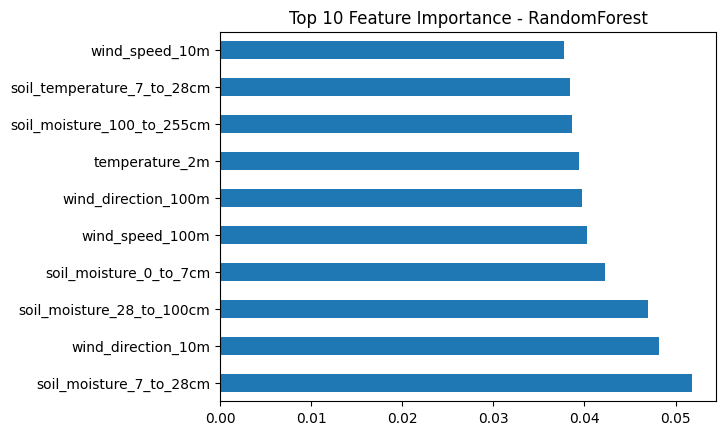

In [67]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importance - RandomForest")
plt.show()

In [68]:
selected_features_rf = feature_importances.nlargest(10).index

### Combining Selected Features

In [69]:
X_class_final = X[selected_features_rfecv]


## **4. Data Preparation for Electricity Shutdown**

### Normalization

In [70]:
scaler = MinMaxScaler()
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class_final, y_class, test_size=0.2, random_state=2024)

In [71]:
smote = SMOTE(random_state=2024)
X_train_class_balanced, y_train_class_balanced = smote.fit_resample(X_train_class, y_train_class)

In [72]:
X_train_class_scaled = scaler.fit_transform(X_train_class_balanced)
X_test_class_scaled = scaler.transform(X_test_class)

## **5. Modeling and Evaluation for Electricity Shutdown**

### Tuning RandomForest Classifier

In [73]:
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # Use both L1 and L2 regularization
    'C': [0.001, 0.01, 0.1, 1, 10],  # Different strengths for regularization
    'solver': ['liblinear'],  # Solver that works with L1 regularization
    'class_weight': [None, 'balanced']  # Handle imbalanced classes
}

lr = LogisticRegression(max_iter=1000)

# Step 3: Perform Grid Search to find the best parameters
grid_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_class_scaled, y_train_class_balanced)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='f1')

### Predictions and Evaluation

In [74]:
y_pred_lr = grid_lr.best_estimator_.predict(X_test_class_scaled)
f1_lr = f1_score(y_test_class, y_pred_lr)
print(f"Optimized F1 Score for Logistic Regression: {f1_lr:.4f}")

# Print the best hyperparameters
print("Best hyperparameters for Logistic Regression:", grid_lr.best_params_)

Optimized F1 Score for Logistic Regression: 0.0079
Best hyperparameters for Logistic Regression: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


## **6. Feature Selection for Precipitation**

### Separate Features and Target Variable

In [75]:
X_reg = train.drop(columns=['precipitation', 'electricity_shutdown'])
y_reg = train['precipitation']

print("X    : ", X_reg.shape)
print("y_reg: ", y_reg.shape)

X    :  (16093, 32)
y_reg:  (16093,)


### Univariate Selection (f_regression)

bestfeatures = SelectKBest(score_func=f_regression, k=10)
X_reg = bestfeatures.fit_transform(X_reg, y_reg)

### Recursive Feature Elimination with Cross-Validation (RFECV)

In [76]:
model_lr = LinearRegression()
rfecv_reg = RFECV(estimator=model_lr, step=1, cv=5, scoring='neg_mean_squared_error')
rfecv_reg.fit(X_reg, y_reg)

RFECV(cv=5, estimator=LinearRegression(), scoring='neg_mean_squared_error')

In [77]:
selected_features_rfecv_reg = X_reg.columns[rfecv_reg.support_]
print("Selected Features by RFECV: ", selected_features_rfecv_reg)

Selected Features by RFECV:  Index(['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m',
       'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'global_tilted_irradiance',
       'terrestrial_radiation', 'is_day'],
      dtype='object')


### Feature Importance (RandomForestRegressor)

In [78]:
rf_reg = RandomForestRegressor(random_state=2024)
rf_reg.fit(X_reg, y_reg)

RandomForestRegressor(random_state=2024)

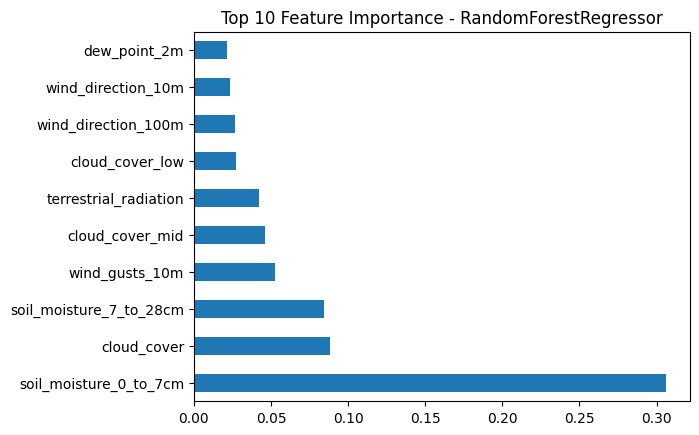

In [79]:
feature_importances_reg = pd.Series(rf_reg.feature_importances_, index=X_reg.columns)
feature_importances_reg.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importance - RandomForestRegressor")
plt.show()

In [80]:
selected_features_rf_reg = feature_importances_reg.nlargest(10).index

### Combining Selected Features

In [81]:
final_selected_features_reg = list(set(selected_features_rfecv_reg) | set(selected_features_rf_reg))
X_reg_final = X_reg[final_selected_features_reg]

## **7. Data Preparation for Precipitation**

### Data Splitting

In [82]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_final, y_reg, test_size=0.2, random_state=2024)

## **8. Modeling and Evaluation for Precipitation**

### Tuning XGBoost for Regression

In [83]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 7),
    'gamma': uniform(0, 0.3),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(1, 1.5)
}
xgb = XGBRegressor(random_state=2024, tree_method='gpu_hist')
randomized_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, 
                                    n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
randomized_search.fit(X_train_reg, y_train_reg)

y_pred_reg = randomized_search.best_estimator_.predict(X_test_reg)
rmse_xgb = np.sqrt(mean_squared_error(y_pred_reg, y_test_reg))
print(f"RMSE for XGBoost: {rmse_xgb:.4f}")

ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:34:44] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [23:34:44] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
157 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:34:45] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [23:34:45] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:34:46] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [23:34:46] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:34:46] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [23:34:45] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device



### Predictions and RMSE

In [40]:
y_pred_reg = grid_xgb.best_estimator_.predict(X_test_reg)
rmse_xgb = np.sqrt(mean_squared_error(y_pred_reg, y_test_reg))
print(f"RMSE for XGBoost: {rmse_xgb:.4f}")

RMSE for XGBoost: 0.3634


## **9. Final Score**

In [43]:
final_score = rmse_xgb * (1 - rf_f1)
print(f"Final Score: {final_score:.4f}")

NameError: name 'rf_f1' is not defined

## **10. Prediction and Submission File**

### Load Data Test

In [42]:
test = pd.read_csv("Test Set.csv", header=0, encoding='unicode_escape', delimiter=';')

test = test.replace(',', '.', regex=True)

test.head()

,ID,time,temperature_2m (EEC),relative_humidity_2m (%),dew_point_2m (EEC),apparent_temperature (EEC),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),...,soil_moisture_28_to_100cm (m?/m?),soil_moisture_100_to_255cm (m?/m?),shortwave_radiation (W/m?),direct_radiation (W/m?),diffuse_radiation (W/m?),direct_normal_irradiance (W/m?),global_tilted_irradiance (W/m?),terrestrial_radiation (W/m?),is_day (),sunshine_duration (s)
0,17521,2024-01-01T00:00,23.7,94.0,22.8,28.6,1011.6,987.5,NaN,56.0,...,0.184,0.206,0,0,0,0,0,0,0,0
1,17522,2024-01-01T01:00,NaN,95.0,22.6,28.4,1010.8,NaN,49.0,20.0,...,0.185,0.206,0,0,0,0,0,NaN,0,0
2,17523,2024-01-01T02:00,NaN,95.0,22.5,28.1,1010.3,986.2,NaN,37.0,...,0.185,0.206,0,0,0,0,0,0,0,0
3,17524,2024-01-01T03:00,NaN,88.0,22.3,29.4,1010.3,NaN,97.0,NaN,...,0.185,0.206,0,0,0,0,0,0,0,0
4,17525,2024-01-01T04:00,NaN,90.0,22.4,29.1,1010.3,NaN,100.0,NaN,...,0.185,0.206,0,0,0,0,0,0,0,0


In [43]:
test.columns = [
    'ID', 'time', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'apparent_temperature', 'pressure_msl', 'surface_pressure', 'cloud_cover',
    'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'vapour_pressure_deficit',
    'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'wind_direction_100m',
    'wind_gusts_10m', 'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
    'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm',
    'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
    'soil_moisture_100_to_255cm', 'shortwave_radiation', 'direct_radiation',
    'diffuse_radiation', 'direct_normal_irradiance', 'global_tilted_irradiance',
    'terrestrial_radiation', 'is_day', 'sunshine_duration'
]

In [44]:
object_columns = test.select_dtypes(include=['object'])
object_column_names = object_columns.columns
print(object_column_names)

Index(['time', 'temperature_2m', 'dew_point_2m', 'apparent_temperature',
       'pressure_msl', 'surface_pressure', 'vapour_pressure_deficit',
       'wind_speed_10m', 'wind_speed_100m', 'wind_gusts_10m',
       'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm',
       'direct_normal_irradiance', 'terrestrial_radiation',
       'sunshine_duration'],
      dtype='object')


In [45]:
object_to_float = [
    'temperature_2m', 'dew_point_2m', 'apparent_temperature',
    'pressure_msl', 'surface_pressure', 'vapour_pressure_deficit',
    'wind_speed_10m', 'wind_speed_100m', 'wind_gusts_10m',
    'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
    'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm',
    'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
    'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm',
    'direct_normal_irradiance', 'terrestrial_radiation', 'sunshine_duration'
]

test[object_to_float] = test[object_to_float].astype(float)

In [46]:
test_ids = test['ID']

In [47]:
test = test.drop(columns = ['ID', 'time'])

In [48]:
test.fillna(test.mean(), inplace=True)

In [49]:
test.duplicated().sum()

0

In [50]:
float_to_int = [
    'relative_humidity_2m', 'cloud_cover', 'cloud_cover_low', 
    'cloud_cover_mid', 'wind_direction_10m', 'wind_direction_100m'
]

test[float_to_int] = test[float_to_int].astype('int64')

In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   temperature_2m                 4368 non-null   float64
 1   relative_humidity_2m           4368 non-null   int64  
 2   dew_point_2m                   4368 non-null   float64
 3   apparent_temperature           4368 non-null   float64
 4   pressure_msl                   4368 non-null   float64
 5   surface_pressure               4368 non-null   float64
 6   cloud_cover                    4368 non-null   int64  
 7   cloud_cover_low                4368 non-null   int64  
 8   cloud_cover_mid                4368 non-null   int64  
 9   cloud_cover_high               4368 non-null   int64  
 10  vapour_pressure_deficit        4368 non-null   float64
 11  wind_speed_10m                 4368 non-null   float64
 12  wind_speed_100m                4368 non-null   f

In [52]:
test

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,...,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,terrestrial_radiation,is_day,sunshine_duration
0,23.700000,94,22.8,28.6,1011.6,987.500000,53,56,2,100,...,0.184000,0.206,0,0,0,0.0,0,0.000000,0,0.000000
1,25.428488,95,22.6,28.4,1010.8,987.027106,49,20,2,100,...,0.185000,0.206,0,0,0,0.0,0,413.920519,0,0.000000
2,25.428488,95,22.5,28.1,1010.3,986.200000,53,37,13,100,...,0.185000,0.206,0,0,0,0.0,0,0.000000,0,0.000000
3,25.428488,88,22.3,29.4,1010.3,987.027106,97,25,3,100,...,0.185000,0.206,0,0,0,0.0,0,0.000000,0,0.000000
4,25.428488,90,22.4,29.1,1010.3,987.027106,100,25,1,100,...,0.185000,0.206,0,0,0,0.0,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,24.400000,91,22.9,29.1,1011.3,987.300000,75,25,3,100,...,0.263049,0.271,0,0,0,0.0,0,0.000000,0,0.000000
4364,24.100000,93,22.9,29.0,1012.1,988.000000,76,45,10,100,...,0.181000,0.271,0,0,0,0.0,0,0.000000,0,0.000000
4365,24.500000,89,22.5,29.5,1012.6,988.500000,85,59,7,93,...,0.181000,0.271,0,0,0,0.0,0,0.000000,0,1323.707511
4366,23.200000,95,22.4,28.0,1012.7,988.500000,53,31,6,71,...,0.181000,0.271,0,0,0,0.0,0,413.920519,0,0.000000


### Prediction

In [53]:
test_class_scaled = scaler.transform(test[final_selected_features])
test_class_pred = grid_rf.best_estimator_.predict(test_class_scaled)

In [54]:
test_reg_scaled = test[final_selected_features_reg]
test_reg_pred = grid_xgb.best_estimator_.predict(test_reg_scaled)

### Submission

In [55]:
submission = pd.DataFrame(data = {"ID": test_ids, "precipitation (mm)": test_reg_pred, "electricity_shutdown": test_class_pred})
submission.to_csv("submission.csv", index = False)

In [56]:
submission

,ID,precipitation (mm),electricity_shutdown
0,17521,0.225588,0
1,17522,0.077760,0
2,17523,0.133377,0
3,17524,0.174354,0
4,17525,0.123663,0
...,...,...,...
4363,21884,0.061800,1
4364,21885,0.121303,1
4365,21886,0.097327,0
4366,21887,0.060481,0


In [57]:
submission.electricity_shutdown.value_counts()

electricity_shutdown
0    4319
1      49
Name: count, dtype: int64